In [1]:
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from visualize import calc_angle_error, euler_to_vec, vec_to_euler, draw_gaze
from utils import estimateHeadPose
from pprint import pprint
import scipy.io as sio
from models import MyModelv7
import torch

In [2]:
result = np.load("examples/result.npz")
list(result.keys())
gt_pitchyaws = np.array(result['gt_pitchyaws'])
pred_pitchyaws = np.array(result['pred_pitchyaws'])
filenames = np.array(result['filenames'])

Text(0, 0.5, 'yaw')

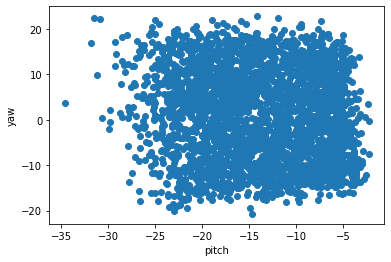

In [3]:
gt_pitchs = np.rad2deg(gt_pitchyaws[:,0])
gt_yaws = np.rad2deg(gt_pitchyaws[:,1])
plt.scatter(x=gt_pitchs, y=gt_yaws)
plt.xlabel("pitch")
plt.ylabel("yaw")

In [4]:
for i in range(len(gt_yaws)):
    if -4 < gt_pitchs[i] < -3:
        print(i, filenames[i])
        print(np.rad2deg(gt_pitchyaws[i]))
        print(np.rad2deg(pred_pitchyaws[i]))
        print(calc_angle_error(pred_pitchyaws[i], gt_pitchyaws[i]))
        

7 p01_day19_0139_face.bmp
[ -3.55251178 -13.7872338 ]
[ -6.25170416 -11.17141045]
3.7519211555212006
35 p01_day54_0074_face.bmp
[ -3.88146205 -10.13933342]
[ -5.41199644 -13.23814544]
3.4469633451548862
44 p01_day03_0405_face.bmp
[-3.86703978 -9.1185584 ]
[ -4.42444201 -10.09447062]
1.1216579524922015
261 p01_day02_0141_face.bmp
[ -3.80608468 -12.37927908]
[ -6.51999826 -13.91466031]
3.1149932056261904
317 p01_day52_0544_face.bmp
[-3.23125375  1.30698426]
[-4.01223412 -0.66275305]
2.1152426080219153
337 p01_day47_0202_face.bmp
[ -3.83377671 -14.3791146 ]
[ -7.78678022 -15.93673525]
4.245770882212394
351 p01_day14_0124_face.bmp
[-3.40447777 -3.03361019]
[-14.66171822  -7.37225091]
12.042484508757418
459 p01_day55_0369_face.bmp
[-3.79654928 -9.15246412]
[-5.49854262 -8.07237262]
2.0138601860038863
461 p01_day45_0388_face.bmp
[-3.84428686 -4.87152973]
[-5.39467294 -5.8416862 ]
1.827221199840541
601 p01_day01_0340_face.bmp
[-3.90091971 -7.3248264 ]
[ -5.55788288 -10.77171205]
3.81377988125

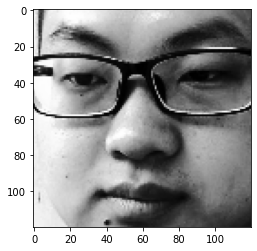

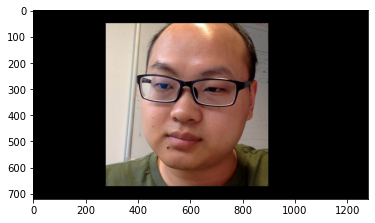

In [5]:
# 420
img = cv2.imread("../datasets/images/p01/day37_0333_face.bmp")
plt.imshow(img)
_ = plt.figure()
img = cv2.imread("../datasets/gaze_estimation/MPIIFaceGaze/p01/day37/0333.jpg")
plt.imshow(img[...,::-1])

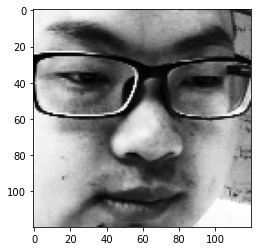

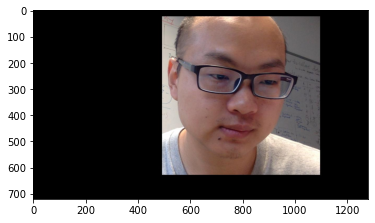

In [6]:
# 146
img = cv2.imread("../datasets/images/p01/day15_0326_face.bmp")
plt.imshow(img)
_ = plt.figure()
img = cv2.imread("../datasets/gaze_estimation/MPIIFaceGaze/p01/day15/0326.jpg")
plt.imshow(img[...,::-1])

[-17.7754576  22.8527094]
[-18.05241879  19.98031652]


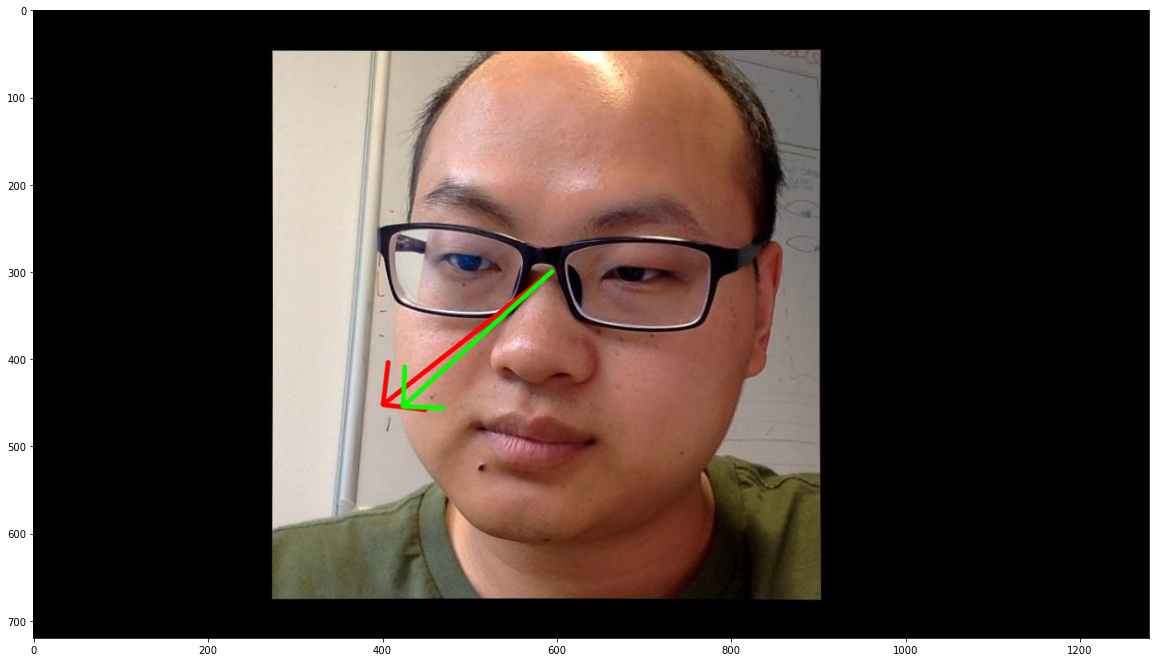

In [7]:
# file = "day52/0544.jpg"
file = "day37/0333.jpg"
img_name = f"../datasets/gaze_estimation/MPIIFaceGaze/p01/{file}"
def get_landmarks():
    with open("../datasets/gaze_estimation/MPIIFaceGaze/p01/p01.txt", "r") as f:
        for line in f.readlines():
            if line.startswith(file):
                break
        line = line.strip().split()
        landmarks = np.array(list(map(int, line[3:15]))).reshape(-1, 2)
        return landmarks, line

def normalizeDataForVisualization(img, face, hr, ht, gc, cam, face_center=None):
    ## normalized camera parameters
    focal_norm = 960 # focal length of normalized camera
    distance_norm_face = 1000 # normalized distance between face and camera
    roiSize_face = (120, 120) # size of cropped face image

    img_u = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## compute estimated 3D positions of the landmarks
    ht = ht.reshape((3,1))
    gc = gc.reshape((3,1))
    hR = cv2.Rodrigues(hr)[0] # rotation matrix
    Fc = np.dot(hR, face) + ht # 3D positions of facial landmarks
    fe = Fc.mean(-1).reshape((3,1))
    for distance_norm, roiSize, et in zip([distance_norm_face], [roiSize_face], [fe]):
        distance = np.linalg.norm(et) # actual distance between eye and original camera
        
        z_scale = distance_norm/distance
        cam_norm = np.array([
            [focal_norm, 0, roiSize[0]/2],
            [0, focal_norm, roiSize[1]/2],
            [0, 0, 1.0],
        ])
        S = np.array([ # scaling matrix
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, z_scale],
        ])
        
        hRx = hR[:,0]
        forward = (et/distance).reshape(3)
        down = np.cross(forward, hRx)
        down /= np.linalg.norm(down)
        right = np.cross(down, forward)
        right /= np.linalg.norm(right)
        R = np.c_[right, down, forward].T # rotation matrix R
        et = Fc[:,:4].mean(-1).reshape((3,1))
        gt_vec_cam = gc - et
        gt_vec_cam /= np.linalg.norm(gt_vec_cam)
        gt_pitchyaw_cam = vec_to_euler(*(gt_vec_cam.reshape(-1)))
        # gt_vec_aligned = np.dot(R, gt_vec_cam)
        # gt_vec_aligned /= np.linalg.norm(gt_vec_aligned)
        return gt_pitchyaw_cam
        

img = cv2.imread(img_name)
cameraCalib = sio.loadmat('./utils/data/calibration/cameraCalib.mat')
camera_matrix = cameraCalib['cameraMatrix']
camera_distortion = cameraCalib['distCoeffs']
img = cv2.undistort(img, camera_matrix, camera_distortion)
face = sio.loadmat('./utils/data/faceModelGeneric.mat')['model']
landmarks, line = get_landmarks()
num_pts = face.shape[1]
facePts = face.T.reshape(num_pts, 1, 3)
landmarks = landmarks.astype(np.float32)
landmarks = landmarks.reshape(num_pts, 1, 2)
hr, ht = estimateHeadPose(landmarks, facePts, camera_matrix, camera_distortion)

landmarks = landmarks.reshape(-1, 2)
gc = np.array([*map(float, line[24:27])])
gt_pitchyaw_cam = normalizeDataForVisualization(img, face, hr, ht, gc, camera_matrix)
img = draw_gaze(img, landmarks[:4].mean(0), gt_pitchyaw_cam, thickness=4, color=(0, 0, 255), length=500)

match = file.split('/')
match = f"p01_{match[0]}_{match[1][:-4]}_face.bmp"
for i in range(len(filenames)):
    if filenames[i] == match:
        pred_pitchyaw_cam = pred_pitchyaws[i]
img = draw_gaze(img, landmarks[:4].mean(0), pred_pitchyaw_cam, thickness=4, color=(0, 255, 0), length=500)
plt.figure(figsize=(20, 20))
plt.imshow(img[...,::-1])
print(np.rad2deg(gt_pitchyaw_cam))
print(np.rad2deg(pred_pitchyaw_cam))

In [8]:
gaze_model = MyModelv7(arch="proxyless-w0.3-r176_imagenet")
ckpt = torch.load(os.path.join("./han1weights/epoch=48-val_loss=15.9853-val_angle_error=2.76.ckpt"), map_location='cpu')
state_dict = ckpt['state_dict']
keys = list(state_dict.keys())
for key in keys:
    state_dict[key.replace("model.","")] = state_dict.pop(key)
gaze_model.load_state_dict(state_dict)
gaze_model.eval()
gaze_model.cuda()
print("Model OK")

Model OK


# Image Demo

[-10.52063204 -10.98384552]
[-7.98003645 -4.79851804]
[-10.79477409   4.39591962]
[-7.61619585 -9.13435309]
[-8.40332026  3.0991561 ]
[-5.06880972 -2.52955719]


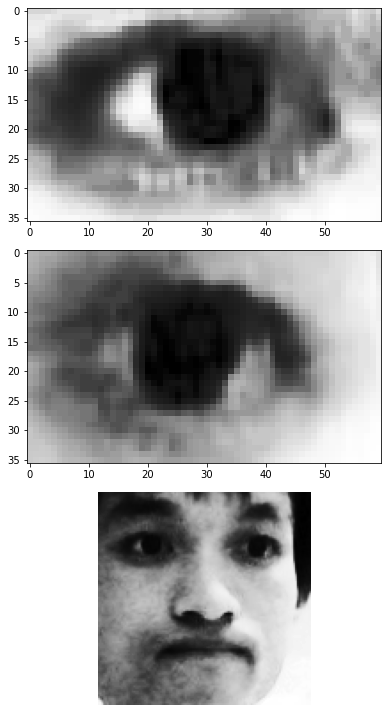

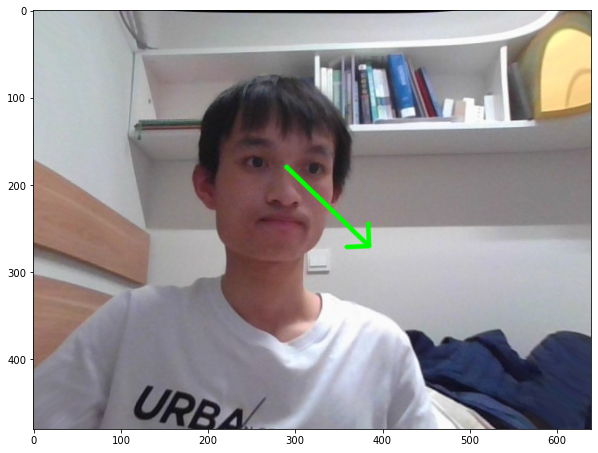

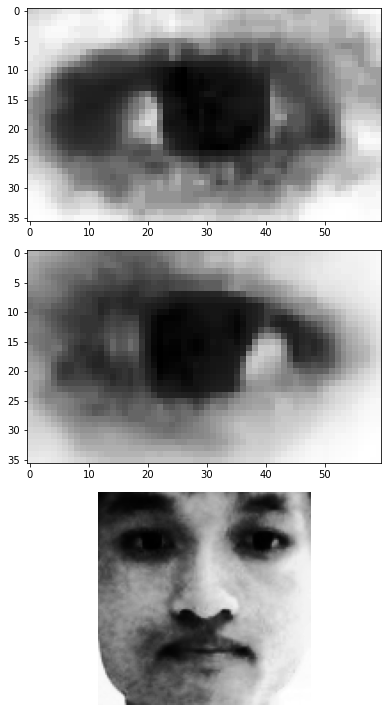

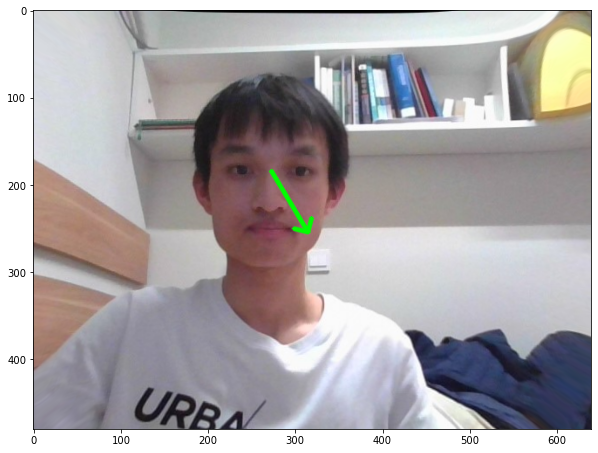

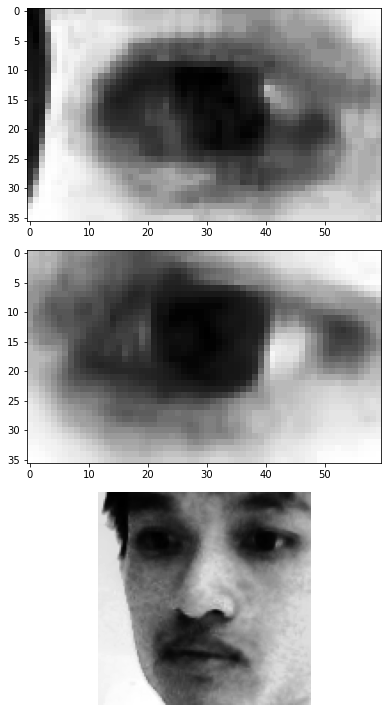

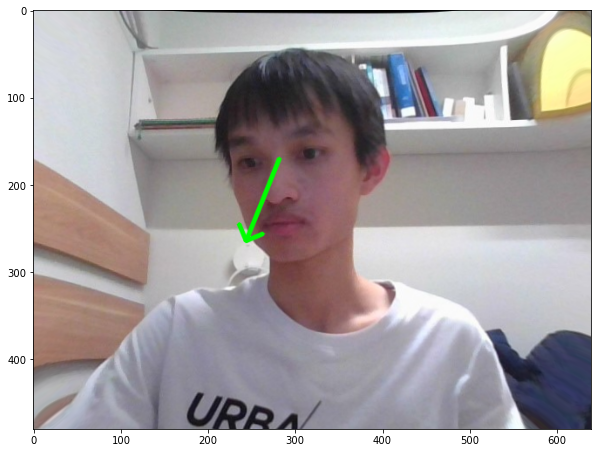

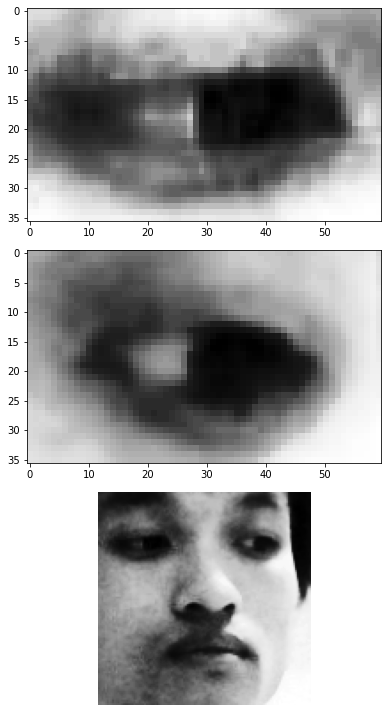

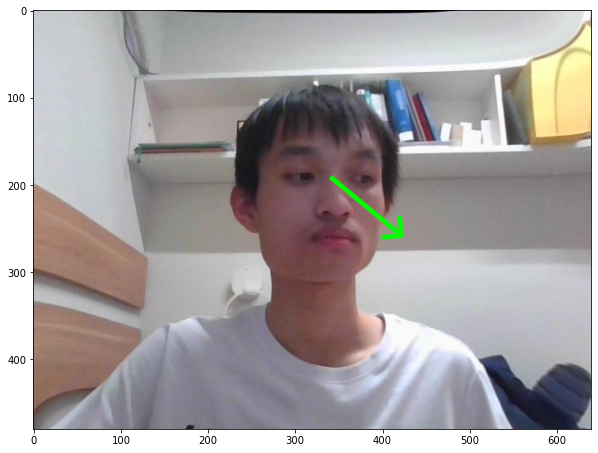

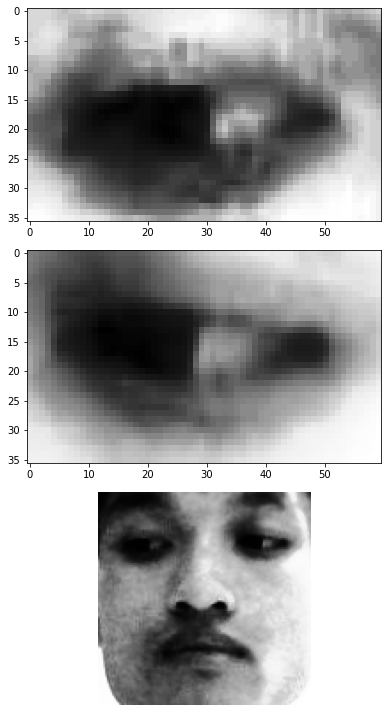

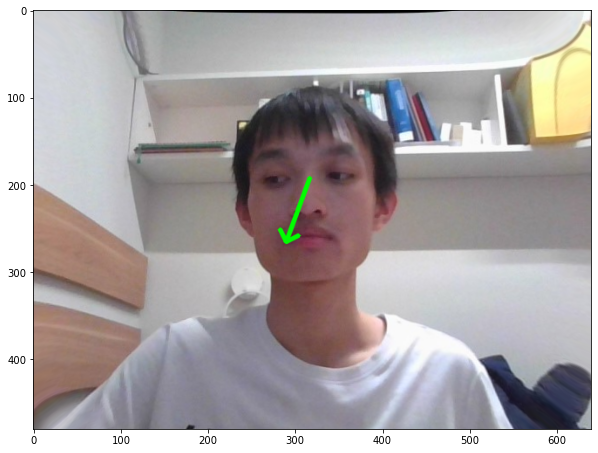

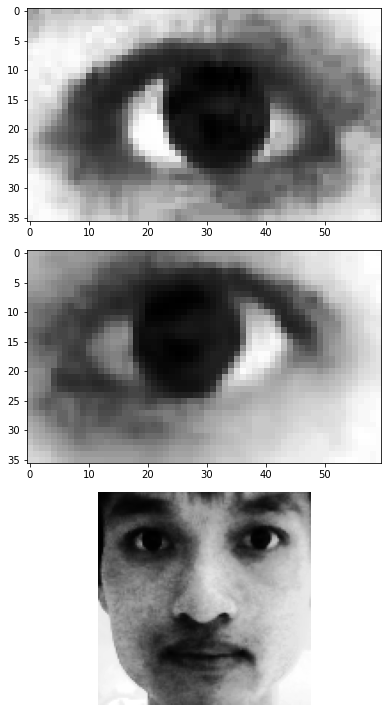

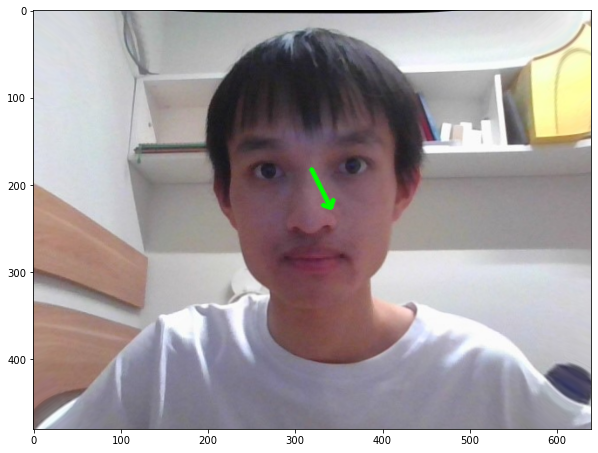

In [9]:
def normalizeDataForInference(img, face, hr, ht, cam):
    ## normalized camera parameters
    focal_norm = 960 # focal length of normalized camera
    distance_norm_eye = 600 # normalized distance between eye and camera
    distance_norm_face = 1000 # normalized distance between face and camera
    roiSize_eye = (60, 36) # size of cropped eye image
    roiSize_face = (120, 120) # size of cropped face image

    img_u = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## compute estimated 3D positions of the landmarks
    ht = ht.reshape((3,1))
    hR = cv2.Rodrigues(hr)[0] # rotation matrix
    Fc = np.dot(hR, face) + ht # 3D positions of facial landmarks

    if Fc.shape[-1] == 6:
        re = 0.5*(Fc[:,0] + Fc[:,1]).reshape((3,1)) # center of eye on the left side of image (right eye)
        le = 0.5*(Fc[:,2] + Fc[:,3]).reshape((3,1)) # center of eye on the right side of image (left eye)
    else:
        re = Fc[:,0].reshape((3,1))
        le = Fc[:,1].reshape((3,1))
    fe = Fc.mean(-1).reshape((3,1))
    
    ## normalize each eye
    data = []
    for distance_norm, roiSize, et in zip([distance_norm_eye, distance_norm_eye, distance_norm_face], [roiSize_eye, roiSize_eye, roiSize_face], [re, le, fe]):
        ## ---------- normalize image ----------
        distance = np.linalg.norm(et) # actual distance between eye and original camera
        
        z_scale = distance_norm/distance
        cam_norm = np.array([
            [focal_norm, 0, roiSize[0]/2],
            [0, focal_norm, roiSize[1]/2],
            [0, 0, 1.0],
        ])
        S = np.array([ # scaling matrix
            [1.0, 0.0, 0.0],
            [0.0, 1.0, 0.0],
            [0.0, 0.0, z_scale],
        ])
        
        hRx = hR[:,0]
        forward = (et/distance).reshape(3)
        down = np.cross(forward, hRx)
        down /= np.linalg.norm(down)
        right = np.cross(down, forward)
        right /= np.linalg.norm(right)
        R = np.c_[right, down, forward].T # rotation matrix R
        
        W = np.dot(np.dot(cam_norm, S), np.dot(R, np.linalg.inv(cam))) # transformation matrix
        
        img_warped = cv2.warpPerspective(img_u, W, roiSize) # image normalization
        img_warped = cv2.equalizeHist(img_warped)
        data.append(img_warped)

        if distance_norm == distance_norm_face:
             data.append(R)
    return data

def handle_image(raw_img, landmarks):
    cam_params = np.load("./demo/calibration/calibration_result.npz")
    camera_matrix = cam_params["mtx"]
    camera_distortion = cam_params["dist"]
    img = cv2.undistort(raw_img, camera_matrix, camera_distortion)
    
    if len(landmarks) == 6:
        face_model = sio.loadmat('./demo/6 points-based face model.mat')['model']
    elif len(landmarks) == 5:
        face_model = np.load("./demo/five_point_face_model.npy").T
    elif len(landmarks) == 4:
        face_model = np.load("./demo/four_point_face_model.npy")
    else:
        raise NotImplementedError

    num_pts = face_model.shape[1]
    facePts = face_model.T.reshape(num_pts, 1, 3)
    landmarks = landmarks.astype(np.float32)
    landmarks = landmarks.reshape(num_pts, 1, 2)
    
    if len(landmarks) == 4:
        hr, ht = estimateHeadPose(landmarks, facePts, camera_matrix, camera_distortion, flags=cv2.SOLVEPNP_AP3P)
    else:
        hr, ht = estimateHeadPose(landmarks, facePts, camera_matrix, camera_distortion)
    
    data = normalizeDataForInference(img, face_model, hr, ht, camera_matrix)
    leye_image, reye_image, face_image, R = data
    plt.figure(figsize=(10, 10))
    plt.subplot(3,1,1)
    plt.imshow(leye_image, plt.cm.gray)
    plt.subplot(3,1,2)
    plt.imshow(reye_image, plt.cm.gray)
    plt.subplot(3,1,3)
    plt.imshow(face_image, plt.cm.gray)
    plt.axis("off")
    plt.tight_layout()
    
    with torch.no_grad():
        leye = torch.FloatTensor(leye_image).reshape(1,1,*leye_image.shape).cuda()
        reye = torch.FloatTensor(reye_image).reshape(1,1,*reye_image.shape).cuda()
        face = torch.FloatTensor(face_image).reshape(1,1,*face_image.shape).cuda()
        pred_pitchyaw_aligned = (gaze_model(leye, reye, face) / 100.0).detach().cpu().numpy()[0]
    pred_vec_aligned = euler_to_vec(*pred_pitchyaw_aligned)
    pred_vec_cam = np.dot(np.linalg.inv(R), pred_vec_aligned)
    pred_vec_cam /= np.linalg.norm(pred_vec_cam)
    pred_pitchyaw_cam = vec_to_euler(*pred_vec_cam)
    if num_pts == 6:
        img = draw_gaze(img, landmarks[:4].mean(0)[0], pred_pitchyaw_cam, thickness=4, color=(0, 255, 0), length=500)
    else:
        img = draw_gaze(img, landmarks[:2].mean(0)[0], pred_pitchyaw_cam, thickness=4, color=(0, 255, 0), length=500)
    return img, pred_pitchyaw_cam

with open("./tools/annos.txt", "r") as f:
    samples = f.readlines()
for sample in samples:
    sample = sample.strip().split()
    img_name = sample[0]
    landmarks = np.array([*map(int,sample[1:])]).reshape(-1, 2)
    img = cv2.imread(img_name)
    img, pred_pitchyaw_cam = handle_image(img, landmarks)
    plt.figure(figsize=(10, 10))
    plt.imshow(img[...,::-1])
    print(np.rad2deg(pred_pitchyaw_cam))
    

In [ ]:
# 3 4p
[[-0.25389822]
 [-0.14025697]
 [-0.00159183]]
[[ 34.43061857]
 [-48.87769432]
 [585.04960783]]
[-5.80143557  4.12173258]

In [ ]:
# 3 6p
[[-0.34038807]
 [-0.23152897]
 [ 0.00361957]]
[[ 32.17452065]
 [-45.95745691]
 [556.42167116]]
[ -9.11556265 -13.66414227]

In [ ]:
# 4 4p
[[-0.37302264]
 [ 0.09743264]
 [-0.01264244]]
[[  9.34508103]
 [-48.07389563]
 [580.00190883]]
[-7.31717537  6.33650755]

In [ ]:
# 4 6p
[[-0.3930327 ]
 [ 0.01506888]
 [-0.03731727]]
[[  7.12555919]
 [-46.8335285 ]
 [568.08626722]]
[-5.40752951  7.04419587]